# Calculate the network proximity between many disease pairs

Evaluate how likely it is to get network overlap between diseases

Requires DisGeNet download https://www.disgenet.org/downloads

For figure 2f

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random


# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set_style('white')

import sys

% matplotlib inline
from IPython.display import display

# Get disease genes from somewhere... maybe DisGeNet?

In [3]:
disgenet_df = pd.read_csv('/Users/brinrosenthal/Documents/CCBB_tickets_data/DisGeNet/all_gene_disease_associations.tsv.gz',sep='\t')
print(len(disgenet_df))
disgenet_df.head()

628685


,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.857,0.172,C0001418,Adenocarcinoma,group,C04,Neoplastic Process,0.01,NaN,2008.0,2008.0,1,0,LHGDN
1,1,A1BG,0.857,0.172,C0002736,Amyotrophic Lateral Sclerosis,disease,C10;C18,Disease or Syndrome,0.01,1.0,2009.0,2009.0,1,0,BEFREE
2,1,A1BG,0.857,0.172,C0013080,Down Syndrome,disease,C10;C16,Disease or Syndrome,0.01,1.0,2011.0,2011.0,1,0,BEFREE
3,1,A1BG,0.857,0.172,C0017636,Glioblastoma,disease,C04,Neoplastic Process,0.01,1.0,2014.0,2014.0,1,0,BEFREE
4,1,A1BG,0.857,0.172,C0019209,Hepatomegaly,phenotype,C06;C23,Finding,0.30,NaN,2017.0,2017.0,1,0,CTD_human


In [4]:
disgenet_df['source'].value_counts().head()

BEFREE          357934
HPO             125532
CTD_human        43392
LHGDN            13096
BEFREE;LHGDN     12458
Name: source, dtype: int64

In [5]:
print(sum(disgenet_df['score']>.2))

83350


In [6]:
display(disgenet_df['NofSnps'].value_counts().head())
print(len(disgenet_df[disgenet_df['NofSnps']>0]))
# filtering by score > 0.2
disgenet_df = disgenet_df[disgenet_df['score']>.2]
print(len(disgenet_df))
display(disgenet_df['diseaseName'].value_counts().head())


0    573498
1     35036
2      9149
3      3522
4      1822
Name: NofSnps, dtype: int64

55187
83350


Intellectual Disability          2037
Malignant neoplasm of breast     1034
Schizophrenia                     881
Liver Cirrhosis, Experimental     770
Colorectal Cancer                 677
Name: diseaseName, dtype: int64

In [7]:
print(disgenet_df['diseaseName'].value_counts().loc['Kartagener Syndrome'])
print(disgenet_df['diseaseName'].value_counts().loc['Psoriasis'])
print(disgenet_df['diseaseName'].value_counts().loc['Atherosclerosis'])

38
59
65


In [9]:
disgenet_df['source'].value_counts().head()

CTD_human                 43392
BEFREE;CTD_human           7938
GENOMICS_ENGLAND           5124
BEFREE;PSYGENET            2085
BEFREE;CTD_human;LHGDN     1968
Name: source, dtype: int64

In [10]:
# print out some disease options
disgenet_VC = disgenet_df['diseaseName'].value_counts()
for d in disgenet_VC[disgenet_VC<100].head(50).index.tolist():
    print(str(d)+': '+str(disgenet_VC.loc[d]))


Generalized seizures: 99
Weight Gain: 99
Generalized Absence Seizures: 99
Seizures, Sensory: 99
Visual seizure: 99
Tonic - clonic seizures: 99
Myoclonic Seizures: 99
Tonic Seizures: 99
Convulsive Seizures: 99
Nonepileptic Seizures: 99
Seizures, Clonic: 99
Epileptic drop attack: 99
Atonic Absence Seizures: 99
Jacksonian Seizure: 99
Vertiginous seizure: 99
Olfactory seizure: 99
Seizures, Somatosensory: 99
Convulsions: 99
Seizures, Auditory: 99
Non-epileptic convulsion: 99
Gustatory seizure: 99
Epileptic Seizures: 99
Seizures, Focal: 99
Absence Seizures: 99
Single Seizure: 99
Adenocarcinoma of large intestine: 98
Myocardial Failure: 98
Pancreatic Neoplasm: 98
Left-Sided Heart Failure: 98
Heart Decompensation: 98
Retinitis Pigmentosa: 98
Heart Failure, Right-Sided: 98
Hematologic Neoplasms: 97
Kidney Failure, Acute: 97
Fibrosis, Liver: 97
Congenital Disorders of Glycosylation: 97
Malignant neoplasm of pancreas: 95
Pulmonary Fibrosis: 93
Spastic Paraplegia, Hereditary: 91
Congenital myopath

In [11]:
# Load pcnet
G_pcnet = nx.read_gpickle('/Users/brinrosenthal/Documents/CCBB_tickets_data/PCnet/G_PCnet.gpickle')
print(len(G_pcnet.nodes()))
print(len(G_pcnet.edges()))

19781
2724724


In [12]:
# pick a few disease which have similar gene sizes

disease_list = ['Psoriasis','Atherosclerosis','Kartagener Syndrome']

disgenet_focal = disgenet_df[disgenet_df['diseaseName'].isin(disease_list)]
print(len(disgenet_focal))


focal_disease='Kartagener Syndrome'
focal_genes = disgenet_focal[disgenet_focal['diseaseName']==focal_disease]['geneSymbol'].tolist()
print(len(focal_genes))
print(focal_genes[0:5])

print(len(np.unique(np.intersect1d(G_pcnet.nodes(),focal_genes))))


162
38
['DNAH5', 'GAS8', 'RPGR', 'SPAG1', 'OFD1']
37


In [14]:
# load the ASD-CHD seed genes

ASD_HC = pd.read_csv('../../../data/ASD_HC.txt',names=['HC_genes'])

ASD_HC = ASD_HC['HC_genes'].tolist()
print(len(ASD_HC))


CHD_HC = pd.read_csv('../../../data/CHD_HC_new.txt',names=['HC_genes'])
CHD_HC = CHD_HC['HC_genes'].tolist()
print(len(CHD_HC))

# set ASD or CHD focal genes to test localization of input gene set
# focal_disease='ASD'
# focal_genes=ASD_HC

65
66


# Check network localization of focal disease

In [17]:
# import network localization methods

sys.path.append('../netprop_zscore_code/')
import network_localization

In [18]:
print(len(np.unique(np.intersect1d(G_pcnet.nodes(),focal_genes))))

37


In [19]:
# set numreps to 5000 for full run

num_reps=100
focal_numedges_list, focal_numedges_rand, focal_LCC_list, focal_LCC_size_rand = network_localization.localization(G_pcnet,
                                                                     focal_genes = focal_genes,
                                                                     num_reps = num_reps, 
                                                                     sample_frac = 1, 
                                                                     method = 'both', 
                                                                     plot = False,print_counter=True)

0
25
50
75


0.0


Text(0.5,1,'permutation p = 0.0')

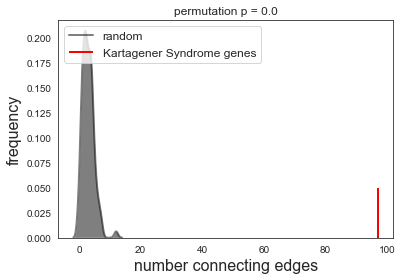

In [20]:
sns.set_style('white')
sns.set_style('white')
plt.vlines(np.mean(focal_numedges_list),ymin=0,ymax=0.05,color='r',lw=2,label=focal_disease+' genes')
sns.kdeplot(focal_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number connecting edges',fontsize=16)

# print the z-score and fdr
focal_NE_z = (np.mean(focal_numedges_list)-np.mean(focal_numedges_rand))/np.std(focal_numedges_rand)

from scipy.special import ndtr
print(1-ndtr(focal_NE_z))
plt.title('permutation p = '+str(1-ndtr(focal_NE_z)))
# from scipy.stats import ks_2samp
# print(ks_2samp(focal_numedges_list,focal_numedges_rand))
# plt.savefig('localization_figures/'+focal_disease+'_numedges.png',dpi=300,bbox_inches='tight')

In [22]:
print(len(np.intersect1d(ASD_HC,focal_genes)))
print(len(np.intersect1d(CHD_HC,focal_genes)))

0
0


In [23]:
print(focal_genes)

['DNAH5', 'GAS8', 'RPGR', 'SPAG1', 'OFD1', 'DNAH11', 'CCNO', 'LRRC6', 'DNAH1', 'DNAI1', 'STK36', 'NME8', 'ZMYND10', 'HYDIN', 'DNAAF5', 'CCDC40', 'ARMC4', 'DNAAF2', 'CFAP298', 'DNAI2', 'TTC25', 'DNAL1', 'RSPH3', 'CCDC65', 'RSPH1', 'DRC1', 'CCDC114', 'CCDC151', 'DNAAF1', 'PIH1D3', 'DNAAF4', 'RSPH9', 'CCDC39', 'MCIDAS', 'RSPH4A', 'DNAAF3', 'DNAJB13', 'CCDC103']


# Save out gene sets for zscore calculation on AWS

In [24]:
# write out seed genes for AWS processing

# pd.DataFrame({'seed_genes':[focal_genes]}).to_csv(focal_disease+'_seed_genes_200420.tsv',sep='\t')


###### terminal commands to run netprop
python netprop_zscore.py 5000 HC_genes/Kartagener\ Syndrome_seed_genes_200420.tsv ../interactomes/G_PCnet.gpickle Kartagener degree_binning single  
python netprop_zscore.py 5000 HC_genes/Psoriasis_seed_genes_200420.tsv ../interactomes/G_PCnet.gpickle Psoriasis degree_binning single  
python netprop_zscore.py 5000 HC_genes/Atherosclerosis_seed_genes_200420.tsv ../interactomes/G_PCnet.gpickle Atherosclerosis degree_binning single  
